Os seguintes scripts são uma versão Python do curso de Machine Learning do professor Andrew Ng da universidade de Stanford leccionado na plataforma Coursera.

**Nota: Todos os dados e estrutura do exercício pertencem à Universidade de Stanford**

**Ressalva:** Os scripts não estão implementados de forma modular para todas as funções serem consultadas no mesmo Jupyter Notebook - ao contrário da implementação Octave.

# Exercício 1 - Gráfico dos dados

In [2]:
# Importar o numpy para lidar com vectores e matrizes
import numpy as np
# Importar o pandas para ler os dados
import pandas as pd
# Importar o matplotlib para gráficos
import matplotlib.pyplot as plt

# Importar o módulo de matemática
import math 

# Importar o scipy para recorrer ao módulo de optimização
from scipy import optimize

#Matplotlib notebook propriedade
%matplotlib inline

In [3]:
# Ler o ficheiro texto e colocar em variáveis X e y
ex2_file = pd.read_csv('ex2data2.txt', header=None) 
X = np.array(ex2_file.iloc[:,0:2])
y = np.array(ex2_file.iloc[:,2])

print('# de exemplos de treino: {}'.format(len(X)))
m = len(X)

# de exemplos de treino: 118


Os dados descrevem uma situação de uma fábrica de microprocessadores. Cada microprocessador passa por dois processos de qualidade distintos e o gestor da fábrica quer perceber como, com base nestes dois testes, pode mapear os processadores que foram aceitados ou rejeitados para venda.

O resultado de cada teste está mapeado no vector X (2 dimensões) e a decisão de aceitação para venda está mapeada no vector y.

Vamos verificar, graficamente:

In [4]:
def graficoDados(
    X: np.array,
    y: np.array
):
    '''
    Gráfico de pontos 2D por cada microprocessador
    para o Teste 1 e Teste 2.
    Microprocessadores aceites são marcados com um "+"
    e os rejeitados com um símbolo "o".
    
    Argumentos:
        X(np.array): Dados com o resultado do Teste 1 e Teste 2 por microprocessador.
        y(np.array): Resultado de aceitação do microprocessador.
    Retorna:
        None
    '''
    plt.scatter(X[y==0,0], X[y == 0,1], marker='o', edgecolors='black', color='yellow')
    plt.scatter(X[y==1,0], X[y == 1,1], marker='+', facecolors='none', c='black')
    plt.xlabel('Teste 1')
    plt.ylabel('Teste 2')
    plt.legend(('Rejeitado','Aceite'), loc='best', bbox_to_anchor=(1, 0.5))

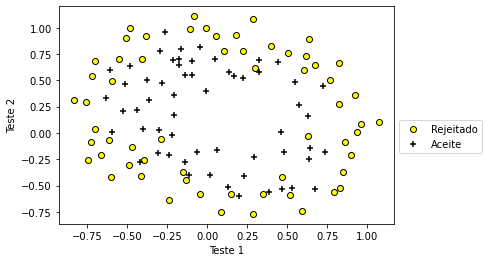

In [5]:
graficoDados(X,y)

O nosso target é binário - vamos utilizar uma regressão logística.
<br>
O exercício tem dois objectivos:
    - Ensinar sobre regularização é como ela é uma ferramenta poderosa para evitar o "overfitting", ou um modelo com elevada variância (será estudado em detalhe mais à frente);
    - Perceber o efeito de features polinomiais para melhorar modelos lineares;
    
<br>
<br>
As equações para a função de custo e o gradiente, ambos com regularização, estão abaixo. Note-se que a parte consistence à regularização é a parte da equação que depende de λ:

<img src="assets/CostFunctionRegularization.JPG">

<img src="assets/GradientRegularization.JPG">

Notemos como o parâmetro λ é capaz de controlar a regularização tanto da função de custo (neste caso, a função log-loss) .
<br>
Um lambda (λ) maior, significa que penalizamos mais os coeficientes e por consequente temos uma maior regularização.

# Exercício 2 -  Regularização

In [7]:
# É impossível encontrarmos uma linha que separe os pontos de forma quase-perfeita. 
# Não conseguimos encontrar uma linha que faça este corte entre classes, como no exercício anterior.

# Visualmente, verificamos que queremos uma espécie de círculo - e é aqui que as features polinomiais nos podem ajudar.
# O grau máximo de polinomial que vamos utilizar é o grau 6.

def mapearFeature(
    X1: np.array, 
    X2: np.array
)-> np.array: 
    """
    Mapeia as features polinomiais até ao grau 6.
    
    Argumentos:
        X1(np.array): Primeira coluna das variáveis originais.
        X2(np.array): Segunda coluna das variáveis originais.
        
    Retorna:
        out(np.array): Resultado das features polinomiais até ao grau 6.
    """
    # Aproveitamos para adicionar a coluna de uns 
    out = np.ones((X1.shape[0],1))
    grau = 6
    for i in range(1,grau+1):
        for j in range(0,i+1):
            nova_feature_polinomial = (X1**(i-j))*(X2**j)
            out = np.hstack((out, nova_feature_polinomial.reshape(len(out),1)))
    return out

In [12]:
# Criar as features polinomiais
X_Poli = mapearFeature(X[:,0], X[:,1])

In [13]:
X_Poli.shape

(118, 28)

Vamos inicial um theta "dummy", de zeros:

In [14]:
# Inicializar theta
theta_inicial = np.zeros(X_Poli.shape[1])

In [16]:
# Colocar lambda (parametro regularização) = 1, chamamos lambdas por causa da palavra-chave reservada do python lambda
lambdas = 1 

In [17]:
# Definir a função sigmóide 
def sigmoide(
    x: np.array
)-> [float, np.array]:
    """
    Computar o valor sigmóide para o vector X
    
    Args:
        x(np.array): Vector com a hipótese original
    Returns:
        (np.array): Vector com a sigmóide resultante
    """
    return(1 / (1 + np.exp(-x)))

In [20]:
# Definir a função de custo e o grafiente com regularização

def custoGradienteTheta(
    theta: np.array,
    X: np.array, 
    y: np.array, 
    lambdas: int
) -> [int, np.array]:
    """
    Define a função de custo com regularização 
    e calcula o gradiente.
    
    Argumentoss:
        theta(np.array): Valores iniciais de theta;
        X(np.array): Features originais;
        y(np.array): Valor target;
        lambdas(int): Lambda aplicado para regularização.
    """
    m = len(X)
    
    # Penalizar o custo quando classificamos mal o outcome positivo
    funcao_custo_1 = np.dot(-y.T,np.log(sigmoide(np.dot(theta.T,X.T))))
    # Penalizar o custo quando classificamos mal o outcome negativo
    funcao_custo_2 = np.dot((1-y).T,np.log(1-sigmoide(np.dot(theta.T,X.T))))
    
    # Calcular a funcao de custo sem regularização
    J = (1/m) * (funcao_custo_1 - funcao_custo_2)
    # Aplicar a regularização à função de custo
    J = J+((lambdas/(2*m))*sum(theta[1:]**2))
    
    reg = (lambdas/m)*theta
    
    # O Theta 0 - Intercept e coluna de uns - não é regularizado
    reg[0] = 0 
    
    # Inicializar gradiente
    grad = (sigmoide(np.dot(theta.T, X.T)) - y.T)
    
    # Aplicar regularização
    grad = (np.dot(grad,X)/m).T + reg
    
    return J, grad

In [21]:
custo, grad = custoGradienteTheta(theta_inicial, X_Poli, y, lambdas)

In [24]:
print('Custo com um theta de zeros {}'.format(np.round(custo,3)))
print('Gradiente com um theta de zeros is {}'.format(np.round(grad,3)))

Custo com um theta de zeros 0.693
Gradiente com um theta de zeros is [0.008 0.019 0.    0.05  0.012 0.038 0.018 0.007 0.008 0.023 0.039 0.002
 0.013 0.003 0.039 0.02  0.004 0.003 0.006 0.004 0.031 0.031 0.001 0.006
 0.    0.007 0.001 0.039]


In [26]:
# Verificar a função de custo com os thetas = vector de uns e com um lambda de 10
theta_teste = np.ones(X_Poli.shape[1])
lambdas = 10

In [27]:
custo, grad = custoGradienteTheta(theta_teste, X_Poli, y, lambdas)

In [31]:
print('Custo com um theta de 1\'s e lambda = 10 {}'.format(np.round(custo,3)))
print('Gradiente com um theta de 1\'s e lambda = 10 {}'.format(np.round(grad,3)))

Custo com um theta de 1's e lambda = 10 3.165
Gradiente com um theta de 1's e lambda = 10 [0.346 0.161 0.195 0.227 0.092 0.244 0.143 0.108 0.102 0.183 0.174 0.087
 0.118 0.086 0.2   0.135 0.095 0.094 0.1   0.091 0.175 0.15  0.087 0.099
 0.085 0.102 0.085 0.182]


# Exercício 3 -  Regularização e Exactidão

Vamos agora minimizar a nossa função de custo em função de theta.

In [32]:
# Inicializar o theta com 0's

theta_inicial = np.zeros(X_Poly.shape[1])

In [33]:
# Colocar o lambda a 1 
lambdas = 1

In [35]:
# parametrizar as opções para a função optimize.minimize
opcoes= {'maxiter': 400}

# implementação baseada na do utilizador Gerges Dib (github user:dibgerge) - optimizamos o nosso custo com base no scipy.
# minimizamos o custo a começar no nosso theta the 0's
# TNC significa Truncated Newton Algorithm e vamos realizar 400 iterações

res = optimize.minimize(custoGradienteTheta,
                        theta_inicial,
                        (X_Poli, y, lambdas),
                        jac=True,
                        method='TNC',
                        options=opcoes)

In [36]:
custo = res.fun
opt_theta = res.x
print('Custo óptimo encontrado pelo método de optimização: {}'.format(float(custo)))
print('Vector de thetas encontrado pelo método de optimização: {}'.format(opt_theta))

Custo óptimo encontrado pelo método de optimização: 0.529002729964516
Vector de thetas encontrado pelo método de optimização: [ 1.27271026  0.62529964  1.18111686 -2.01987398 -0.9174319  -1.43166928
  0.12393227 -0.36553118 -0.35725403 -0.17516292 -1.4581701  -0.05098418
 -0.61558553 -0.27469165 -1.19271298 -0.2421784  -0.20603298 -0.04466178
 -0.27778951 -0.29539514 -0.45645982 -1.04319154  0.02779373 -0.29244871
  0.0155576  -0.32742405 -0.1438915  -0.92467487]


Minimizámos a nossa função de custo para ~0.53, uma grande melhoria relativamente ao custo com os theta's = 0. Como se comporta a nossa fronteira de decisão com base nestes thetas para as features polinomiais?

In [37]:
def graficoFronteiraDecisao(
    theta_optimo: np.array, 
    X: np.array,
    y: np.array
)-> None:
    '''
    Grafico da fronteira de decisão entre as classes 
    y = 0 e y = 1 usando o cálculo "X*theta_optimo"
    
    Argumentos:
        theta_optimo(np.array): Peso a ser aplicado a cada umas variáveis depois da transformação polinomial.
        X(np.array): Os valores das variáveis originais - Teste 1 e Teste 2 para cada microprocessaodor.
        y(np.array): O resultado de aceitação de cada chip.
        
    Retorna:
        None
    '''
    graficoDados(X,y)
    # Usar o contour para colocar a fronteira de decisão
    # Usar um espaço linear bidimensional para mapear a fronteira
    
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros([len(u), len(v)])    
    
    for i in np.arange(0,u.shape[0]):
        for j in np.arange(0,v.shape[0]):
            temp = np.array(u[i])
            z[i,j] = np.dot(mapearFeature(np.array(u[i]).reshape(1), np.array(v[j]).reshape(1)), theta_optimo)
    
    plt.contour(u,v,z.T,0)

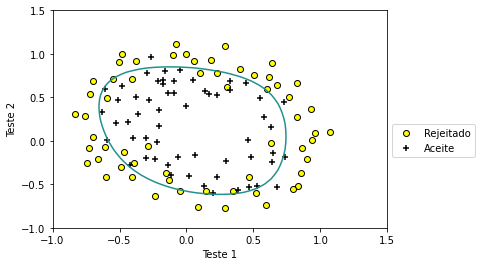

In [39]:
graficoFronteiraDecisao(opt_theta, X,y)

Podemos agora olhar para a exactidão (accuracy) do nosso algoritmo: 

In [40]:
# Calcular a exactidão do algoritmo
def prever(theta: np.array, 
            X: np.array, thres: float)-> np.array:
    #Adicionar uma coluna de uns 
    m = len(X)
    p = sigmoide(np.dot(X, theta.T))
    p = np.where(p>= thres,1,0)
    return p

In [41]:
p = prever(opt_theta, X_Poli, 0.5)

In [42]:
# Verificar a exactidão do algoritmo
print('Usando uma fronteira de decisão de 50%, obtivemos uma exactidão de {:.0%}'.format(sum(p == y)/len(X_Poli)))

Usando uma fronteira de decisão de 50%, obtivemos uma exactidão de 83%
